## 1. 準備

In [1]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
# https://github.com/sw1227/geospatial_analysis/blob/master/geo_util.py
# -*- coding: utf-8 -*-

import pandas as pd
import requests
import urllib.error
from io import BytesIO
import numpy as np
from PIL import Image


class MapTile():
    """ 座標・タイルの種類をもとに地理院タイルを取得して保持するクラス """

    def __init__(self, from_tile, to_tile=None, zoom=None, tile_type="std", ext="png"):
        """ Constructor
        Input
        -----
          from_tile : 取得したい領域内の左上のタイル座標[z, x, y]
          to_tile   : 取得したい領域内の右下のタイル座標[z, x, y] : 単一タイルの時省略可
          zoom      : ズームレベル(from_tile, to_tileのzと異なるズームレベルで取得したければ)
          tile_type : 取得したいタイルの種類
          ext       : 取得したいタイルの拡張子
        Attribute
        ---------
          data  : 取得した地理院タイル(Numpy Array)
          shape : self.dataのshape
        """
        self.from_tile = from_tile
        self.to_tile = to_tile
        self.zoom = zoom
        self.tile_type = tile_type
        self.ext = ext

        # zoomを省略するとfrom_tileと同じになる
        if zoom == None:
            zoom =from_tile[0]

        # to_tileを省略するとfrom_tileと同じになる
        if to_tile == None:
            to_tile = from_tile

        # 地理院タイルのズームレベルの限界
        MAX_ZOOM = 18
        assert zoom <= MAX_ZOOM

        # 指定された領域・ズームレベルおける最も左上のタイル座標
        x1 = from_tile[1] * 2**(zoom - from_tile[0])
        y1 = from_tile[2] * 2**(zoom - from_tile[0])
        # 指定された領域・ズームレベルにおける最も右下のタイル座標
        x2 = (to_tile[1] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1
        y2 = (to_tile[2] + 1) * 2**(zoom - to_tile[0]) - 1 # すぐ右下を考え、それから-1

        # 左上〜右下すべてのタイルの座標を計算
        tile_list = []
        for j in range(y1, y2+1):
            tile_row = []
            for i in range(x1, x2+1):
                tile_row.append([zoom, i, j])
            tile_list.append(tile_row)

        # タイルをダウンロードしてself.dataにセット
        full_tile = []
        for tile_row in tile_list:
            tr = []
            for tile in tile_row:
                tile_url = "http://cyberjapandata.gsi.go.jp/xyz/{tile_type}/{z}/{x}/{y}.{ext}"\
                           .format(tile_type=tile_type, z=tile[0], x=tile[1], y=tile[2], ext=ext)
                if ext in ["png", "jpg"]:
                    # 画像の場合
                    try:
                        response = requests.get(tile_url)
                        img_arr = np.array(Image.open(BytesIO(response.content)))
                    except urllib.error.HTTPError:
                        img_arr = np.zeros((256, 256, 3))
                    tr.append(img_arr)
                elif ext == "txt":
                    # 標高csvの場合
                    try:
                        df = pd.read_csv(tile_url, header=None).replace("e", 0)  # 海: "e" -> 0
                        csv_arr = df.values.astype(np.float)  # numpy array
                    except urllib.error.HTTPError:
                        csv_arr = np.zeros((256, 256))
                    tr.append(csv_arr)
                else:
                    raise ValueError("only {.jpg, .png, .txt} supported")
            tr = np.array(tr)
            full_tile.append(np.hstack(tr))
        self.data = np.vstack(np.array(full_tile))
        self.shape = self.data.shape


    def grad(self, x, y):
        """ 指定された地点での勾配を計算する
        Input
        -----
          x, y: 勾配を計算したい地点の座標
        Output
        -----
          grad_x, grad_y: 勾配のx, y成分
        """
        fx, fy = int(x), int(y) # floor
        dx, dy = x-int(x), y-int(y) # decimal part
        if (dx + dy) < 1:
            grad_x = self.data[fy, fx+1] - self.data[fy, fx]
            grad_y = self.data[fy+1, fx] - self.data[fy, fx]
        else:
            grad_x = self.data[fy+1, fx+1] - self.data[fy+1, fx]
            grad_y = self.data[fy+1, fx+1] - self.data[fy, fx+1]
        return grad_x, grad_y
    
    def grad_norm(self, x, y):
        """ 指定された地点での勾配の大きさを計算する """
        gx, gy = self.grad(x, y)
        return np.sqrt(gx**2 + gy**2)

    def grad_angle(self, x, y):
        """ 指定された地点での勾配の角度を計算する """
        gx, gy = self.grad(x, y)
        return np.arctan2(gy, gx)

In [3]:
# http://www.trail-note.net/tech/coordinate/
def latlon_to_pixel(lat, lon, zoom):
    L = 85.05112878
    x = 2**(zoom+7) * (1 + lon/180.)
    y = 2**(zoom+7) / np.pi * (- np.arctanh(np.sin(np.pi*lat/180.)) + np.arctanh(np.sin(np.pi*L/180.)))
    return x, y

In [4]:
# pixel座標を与えられたタイル座標内でのpixel座標に変換する奴が欲しい

TODO

- heatmapで使ってる地図のタイル座標を見つける
データはnew_dems.jsでnabewari_dem = ... となっている。768
- 緯度経度ベースでjsonを出力する
- jsで緯度経度を3Dの座標に変換する。まずはpixel座標にして、そこからスケール変換
- 今までのpixel座標ベースのコードも修正する
- タイル座標からjsonを作って可視化するまでのフローを簡潔にする。jsonを作るまではコマンドラインでできるぐらいにしたい。
- zのscaleも、実際のスケールをベースにしてオフセットと倍率を調整できるようにしたい
- タイル座標はpythonでjsonを出力するときにjsonの中に入れてしまって、jsはそれを読むようにすれば良い? でも標高はcsv... gpxは緯度経度だから含めなくて良いし...
- 標高データを圧縮したい。0.1mぐらいの精度があればOK

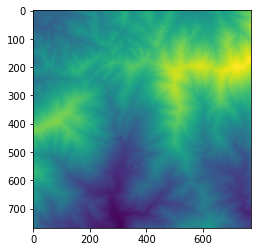

In [5]:
from_tile, to_tile = [15, 29047, 12929], [15, 29049, 12931]
nabewari_tile = MapTile(from_tile, to_tile, zoom=15, tile_type="dem5a", ext="txt")
nabewari_map = MapTile(from_tile, to_tile, zoom=15, tile_type="std", ext="png")
plt.imshow(nabewari_tile.data)

In [7]:
nabewari_tile.data[:5]

array([[  785.48,   782.47,   779.47, ...,  1103.78,  1104.63,  1106.36],
       [  783.57,   780.6 ,   777.74, ...,  1108.31,  1108.97,  1109.77],
       [  781.39,   778.55,   775.91, ...,  1113.17,  1113.83,  1114.05],
       [  778.64,   775.95,   773.3 , ...,  1117.93,  1118.63,  1118.72],
       [  775.69,   773.19,   770.61, ...,  1122.12,  1122.8 ,  1122.86]])

In [8]:
np.savetxt("./static/data/heatmap_dem.csv", nabewari_tile.data.flatten(), newline=",", fmt="%.1f")

In [10]:
len(nabewari_tile.data.flatten())

589824

- 鍋割山荘、番号を緯度経度のjsonに

In [11]:
names = ["/static/img/numbers/Number2.png", "/static/img/numbers/Number3.png", "/static/img/numbers/Number4.png",
         "/static/img/numbers/Number5.png", "/static/img/numbers/Number6.png", "/static/img/numbers/Number7.png",
         "/static/img/numbers/Number8.png", "/static/img/numbers/Number9.png", "/static/img/numbers/Number10.png"]

In [12]:
#  鍋割山稜2 - 10
numbers = [[35.43203333333334, 139.1488945], [35.431705, 139.148025], [35.43167166666667, 139.1444083333333], 
           [35.430875, 139.1437083333333], [35.43199166666667, 139.14305], [35.43361666666667, 139.1429278333333],
           [35.43595, 139.1413721666667], [35.43785, 139.1417528333333], [35.438795, 139.141875]]

In [18]:
elevations = [660., 672.53, 795.12, 792.92, 876.53, 942.83, 1038.5, 1111., 1156.33]

In [20]:
for a, b, c in zip(names, numbers, elevations):
    print(a, b, c)

/static/img/numbers/Number2.png [35.43203333333334, 139.1488945] 660.0
/static/img/numbers/Number3.png [35.431705, 139.148025] 672.53
/static/img/numbers/Number4.png [35.43167166666667, 139.1444083333333] 795.12
/static/img/numbers/Number5.png [35.430875, 139.1437083333333] 792.92
/static/img/numbers/Number6.png [35.43199166666667, 139.14305] 876.53
/static/img/numbers/Number7.png [35.43361666666667, 139.1429278333333] 942.83
/static/img/numbers/Number8.png [35.43595, 139.1413721666667] 1038.5
/static/img/numbers/Number9.png [35.43785, 139.1417528333333] 1111.0
/static/img/numbers/Number10.png [35.438795, 139.141875] 1156.33


In [27]:
number_json = [{"lat": p[0], "lon": p[1], "z": e, "name": n} for p, n, e in zip(numbers, names, elevations)]
with open("./static/data/nabewari_numbers_latlon.json", "w") as f:
    json.dump(number_json, f, indent=2)

In [29]:
number_json[0]

{'lat': 35.43203333333334,
 'lon': 139.1488945,
 'name': '/static/img/numbers/Number2.png',
 'z': 660.0}

In [32]:
sanso = [35.443929,139.14161]
sanso_z = 1272.6

In [33]:
sanso_json = [{"lat": sanso[0], "lon": sanso[1], "z": sanso_z, "name": "/static/img/nabewari_sanso.png"}]

In [35]:
with open("./static/data/nabewari_sanso.json", "w") as f:
    json.dump(sanso_json, f, indent=2)

- 緯度経度ベースの経路JSON

In [37]:
name = "./static/yamap_2017-12-04_08_20.gpx"
with open(name, "r") as f:
    gpx = f.read()
soup = BeautifulSoup(gpx, "lxml")

In [41]:
trail = [{"lat": float(t.get("lat")), "lon": float(t.get("lon")), "z": float(t.ele.string)}\
       for t in soup.find_all("trkpt")]
trail

[{'lat': 35.4317330243396, 'lon': 139.149259748067, 'z': 660.370975494385},
 {'lat': 35.4317330243396, 'lon': 139.149031341205, 'z': 657.59534072876},
 {'lat': 35.431666681576, 'lon': 139.148818776141, 'z': 655.475589752197},
 {'lat': 35.431530517559, 'lon': 139.148668320979, 'z': 665.038822174072},
 {'lat': 35.4315242730411, 'lon': 139.14844754165, 'z': 668.425052642822},
 {'lat': 35.4316013027313, 'lon': 139.148246795069, 'z': 676.214603424072},
 {'lat': 35.4317075852635, 'lon': 139.148065494503, 'z': 674.839115142822},
 {'lat': 35.4317282466548, 'lon': 139.147844966631, 'z': 680.812015533447},
 {'lat': 35.4317396879526, 'lon': 139.147619325797, 'z': 688.532230377197},
 {'lat': 35.431752637993, 'lon': 139.14739318205, 'z': 695.738285064697},
 {'lat': 35.4317690665232, 'lon': 139.147170558701, 'z': 703.36145401001},
 {'lat': 35.4317305935877, 'lon': 139.146954137962, 'z': 703.71057510376},
 {'lat': 35.4317271150979, 'lon': 139.14673092788, 'z': 710.079105377197},
 {'lat': 35.431714626

In [42]:
with open("./static/data/nabewari_trail_latlon.json", "w") as f:
    json.dump(trail, f, indent=2)